/usr/local/anaconda3/envs/gan-ada/lib/python3.7/site-packages/ipykernel_launcher.py:109: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/anaconda3/envs/gan-ada/lib/python3.7/site-packages/ipykernel_launcher.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore

precision of failed:  0.9482310529845741
precision of healthy:  0.7459006968240461
tpr:  0.6718443718443718
fpr:  0.036680626095221124
auc:  0.9361024661345431
f1-score:  0.7864617738066265
roc curve: 


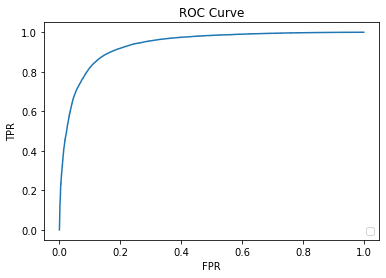

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn import metrics
import joblib
import datetime
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from model.LSTM import LSTM, DatasetUtil
import time

n_days_lookahead = int(input('Please input the length of days lookahead in {5, 7, 15, 30, 45, 60, 90, 120}: '))

if(n_days_lookahead not in [5, 7, 15, 30, 45, 60, 90, 120]):
    print('Input does not meet requirements.')
    exit()

data_type = str(input('Please specify the coverage of the data {A - Manufacturer 1, B - Manufacturer 2, C - Manufacturer 1 & 2, D - Unbalanced}: '))

if(data_type not in ['A', 'B', 'C', 'D']):
    print('Input does not meet requirements.')
    exit()

dit_str = {'A':'mc1', 'B':'mc2', 'C':'mc1_mc2', 'D':'unbalanced'}

model_type = str(input('Please input the type of trained model to use {A - Manufacturer 1, B - Manufacturer 2, C - Manufacturer 1 & 2, D - Unbalanced}: '))

if(model_type not in ['A', 'B', 'C', 'D']):
    print('Input does not meet requirements.')
    exit()

def loadData():

    X = np.load('../data/' + dit_str[data_type] + '/' + str(n_days_lookahead) + '_days_lookahead/smart_test.npy',allow_pickle=True)
    y = np.load('../data/' + dit_str[data_type] + '/' + str(n_days_lookahead) + '_days_lookahead/test_labels.npy',allow_pickle=True)

    X = X.astype('float32')
    y = y.astype('float32')
    return X, y


def get_all_metrics(true, predicted, score):
    confusion_matrix = metrics.confusion_matrix(true, predicted)
    fpr_list, tpr_list, thersholds = roc_curve(true, score)
    roc_auc = auc(fpr_list, tpr_list)
    TP = confusion_matrix[0][0]
    FN = confusion_matrix[0][1]
    FP = confusion_matrix[1][0]
    TN =  confusion_matrix[1][1]
    precision_of_failed = TP / (TP + FP)
    precision_of_healthy = TN / (TN + FN)
    tpr = TP / (TP + FN)
    fpr = FP / (TN + FP)
    auc_score = roc_auc
    f1_score = 2*precision_of_failed*tpr / (precision_of_failed+tpr)
    print('precision of failed: ', precision_of_failed)
    print('precision of healthy: ', precision_of_healthy)
    print('tpr: ', tpr)
    print('fpr: ', fpr)
    print('auc: ', auc_score)
    print('f1-score: ', f1_score)
    print('roc curve: ')
    plt.plot(fpr_list, tpr_list)
    plt.xlim([-0.05, 1.05])  
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
# print('-------------------- LSTM --------------------')
# print('------------------ Loading Data ------------------')

X, y = loadData()

#     print('------------------ LSTM ------------------')
input_size = 11
hidden_size = 64

output_size = 1
num_layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(device)

model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).to(device)
model.load_state_dict(torch.load('../trained_model/'+ dit_str[model_type] + '/' + str(n_days_lookahead) + '_days_lookahead/lstm.pth'))

test_dataset = DatasetUtil(X, y)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

y_pred_list = []
y_true_list = []
y_score_list = []
with torch.no_grad():
    total=0
    for i, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)
        score = model(X)
        predicted = torch.tensor([1 if x[0] > 0.5 else 0 for x in score]).to(device)
        for j in range(0,len(y)):
            y_pred_list.append(int(predicted[j].cpu()))
            y_true_list.append(y[j].cpu())
            y_score_list.append(float(score[j][0]))
get_all_metrics(np.asarray(y_true_list).astype('int'), np.asarray(y_pred_list), np.asarray(y_score_list))
